# Принятие решений в бизнесе

Описание проекта

Аналитик крупного интернет-магазина вместе с отделом маркетинга подготовили список гипотез для увеличения выручки.


Задача: приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. 

## Описание данных

Файл **/datasets/hypothesis.csv** содержит 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами:
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Результаты проведенного A/B-теста описаны в файлах:

Файл **/datasets/orders.csv** содержит информацию о заказах пользователей:
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.


Файл **/datasets/visitors.csv** содержит данные о разделении пользователей на группы А и В:
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

In [3]:
#Загрузим данные и подготовим их к анализу
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 10)})
import scipy.stats as stats
from scipy import stats as st
import math

In [4]:
try:
    hypothesis, orders, visitors = (
    pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv'),  # гипотезы
    pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv'),      # заказы
    pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv'))     # группы пользователей
except:
    hypothesis, orders, visitors = (
    pd.read_csv('/datasets/hypothesis.csv'),  # гипотезы
    pd.read_csv('/datasets/orders.csv'),      # заказы
    pd.read_csv('/datasets/visitors.csv'))     # группы пользователей

In [5]:
# Функция для просмотра основной информации о датафрейме
def preview(data):
    display(data.head())
    
    display(data.info())
    
    print('Всего строк:', data.shape[0],', столбцов:', data.shape[1])
    
    'Дубликатов:', data.duplicated().sum()

In [6]:
preview(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


None

Всего строк: 9 , столбцов: 5


In [7]:
preview(orders)
print('Контрольная дата, начало периода:', orders['date']. min())
print('Контрольная дата, конец периода:', orders['date']. max())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

Всего строк: 1197 , столбцов: 5
Контрольная дата, начало периода: 2019-08-01
Контрольная дата, конец периода: 2019-08-31


In [8]:
preview(visitors)
print('Контрольная дата, начало периода:', visitors['date']. min())
print('Контрольная дата, конец периода:', visitors['date']. max())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

Всего строк: 62 , столбцов: 3
Контрольная дата, начало периода: 2019-08-01
Контрольная дата, конец периода: 2019-08-31


### Предобработка данных

In [10]:
# Изменим названия столбцов для удобства чтения
orders.rename(columns={'transactionId':'transaction_id', 'visitorId':'visitor_id'}, inplace=True)
# столбцы с датами приведем типу данных "datetime" 
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

Для анализа А/B теста проверим правильность разделения пользователей на группы A и B.

In [12]:
print('Всего уникальных пользователей:', len(orders['visitor_id'].unique()))
# Посчитаем уникальных пользователей группы А
group_A = orders.query('group == "A"')
print('Пользователи группы А:', len(group_A['visitor_id'].unique()))
# Посчитаем уникальных пользователей группы В
group_B = orders.query('group == "B"')
print('Пользователи группы В:', len(group_B['visitor_id'].unique()))
# Найдем тех, кто оказался в обоих группах
a_and_b_users = group_A.merge(group_B,on = 'visitor_id')
print('Пользователи, попавшие в группы А и В одновременно:', len(a_and_b_users['visitor_id'].unique()))
# Удалим этих пользователей
matching_visitors = a_and_b_users['visitor_id'].unique()
orders_correct = orders.query('visitor_id not in @matching_visitors')
print('Всего уникальных пользователей после предобработки:', len(orders_correct['visitor_id'].unique()))

Всего уникальных пользователей: 1031
Пользователи группы А: 503
Пользователи группы В: 586
Пользователи, попавшие в группы А и В одновременно: 58
Всего уникальных пользователей после предобработки: 973


**Вывод:** 

В представленных для анализа файлах - данные для приоритизации гипотез и результаты проведения А/В теста

- Данные загружены корректно. 
- Таблицы не содержат пропусков и дубликатов. 
- Для удобства дальнейшей работы названия столбцов приведены к единому стилю. 
- Данные, содержащие дату/время, приведены к формату datetime. 
- Типы данных соответствуют сохранённым в них значениям.
- Данные содержат результаты проведения А/В теста за период с 01.08.2019 по 31.08.2019.
- Анализ распределения пользователей между группами выявил присутствие клиентов с одинаковым id в обоих группах. Для проведения А/В теста важно, чтобы пользователи групп не пересекались. Клиенты, попавшие в обе группы были удалены.

##  Часть 1. Приоритизация гипотез

В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами `Reach`, `Impact`, `Confidence`, `Effort`.

**Задача**
* Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
* Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
* Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

In [15]:
# Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.
pd.options.display.max_colwidth = 250
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis['RICE'] = (hypothesis['Reach']  *hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']
hypothesis[['ICE', 'Hypothesis']].sort_values(by='ICE', ascending=False)

,ICE,Hypothesis
8,16.200000,"Запустить акцию, дающую скидку на товар в день рождения"
0,13.333333,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"
7,11.200000,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"
6,8.000000,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию"
2,7.000000,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"
1,2.000000,"Запустить собственную службу доставки, что сократит срок доставки заказов"
5,1.333333,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов"
3,1.125000,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар"
4,1.000000,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей"


In [16]:
# Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.
hypothesis.sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


На основе полученных результатов можно сделать вывод, что согласно ICE, наибольшие баллы получили гипотезы:
- 8 (Запустить акцию, дающую скидку на товар в день рождения);
- 0 (Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей). 

Однако после использования RICE приоритеты изменились на: 
- 7 (Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок); 
- 2 (Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа); 
- 0 (Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей). 

Это связано с тем, что во время использования ICE охват изменений не учитывался, в то время как RICE принимает его во внимание. Таким образом, в нашем случае наиболее приоритетными гипотезами являются 7, 2 и 0.
Гипотезы 8 и 0 имеют высокие показатели impact и confidence, но у гипотезы 8 охват предполагается меньше, поэтому она не стоит в приоритете проверки по показателю RICE. 

## Часть 2. Анализ A/B-теста
Вы провели A/B-тест и получили результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.

**Задача**
- Проанализируйте A/B-тест

### Построим график кумулятивной выручки по группам. Сделаем выводы и предположения.

In [20]:
orders_correct.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [21]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [22]:
# Cоберем кумулятивные данные. Создадим массив уникальных пар значений дат и групп теста методом drop_duplicates(): 
datesGroups = orders_correct[['date','group']].drop_duplicates()

# Соберём агрегированные кумулятивные по дням данные о заказах
ordersAggregated = datesGroups.apply(
    lambda x: orders_correct[np.logical_and(orders_correct['date'] <= x['date'], orders_correct['group'] == x['group'])]
.agg({
'date' : 'max', 
'group' : 'max', 
'transaction_id' : 'nunique', 
'visitor_id' : 'nunique', 
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# Соберём агрегированные кумулятивные по дням данные о посетителях
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
'date' : 'max', 
'group' : 'max', 
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# Объединим обе таблицы в одну
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']) 
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


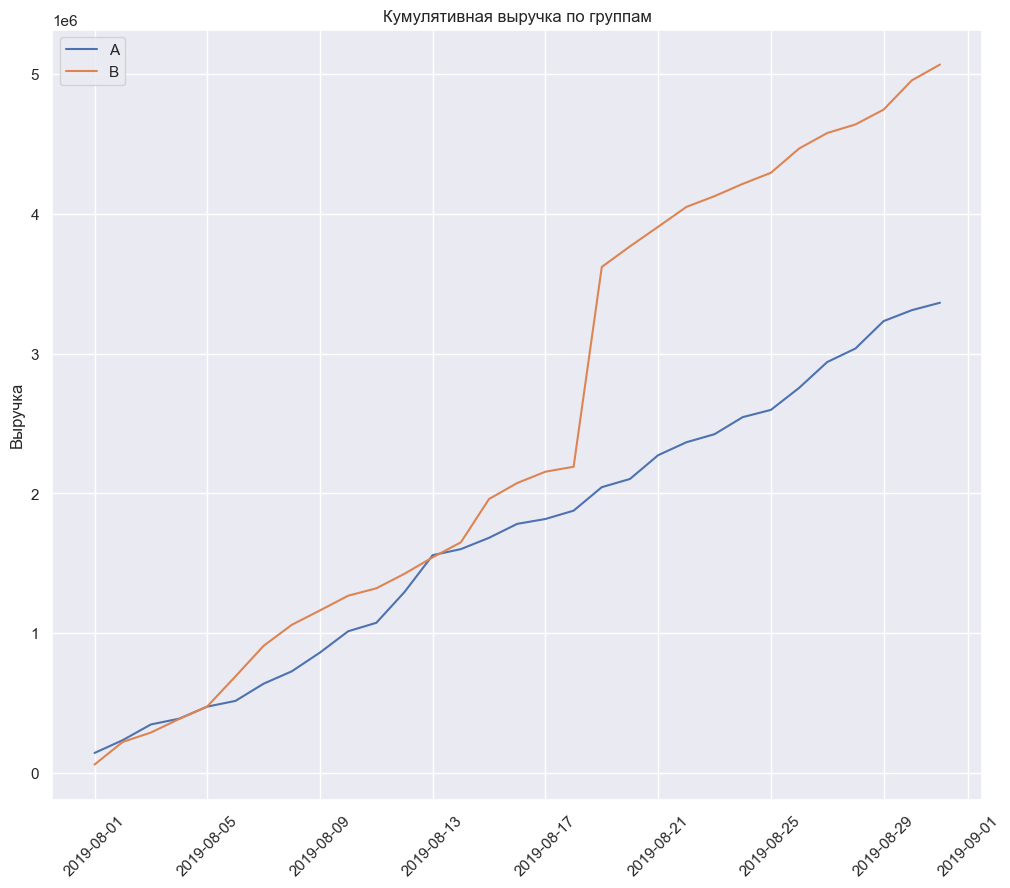

In [23]:
# Построим графики кумулятивной выручки по дням и группам A/B-тестирования: 

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Кумулятивная выручка по группам')
plt.ylabel('Выручка')
plt.xticks(rotation=45)
plt.legend() 
plt.show()

**Вывод:**

- Выручка равномерно увеличивается в течение всего периода теста для обеих групп.
- Однако график выручки групппы В в точке, соответствующей дате 2019-08-19 резко растет. Это может свидетельствовать об увеличении числа заказов, либо о появлении очень дорогих заказов в этот период. 

### Построим график кумулятивного среднего чека по группам. Сделаем выводы и предположения.

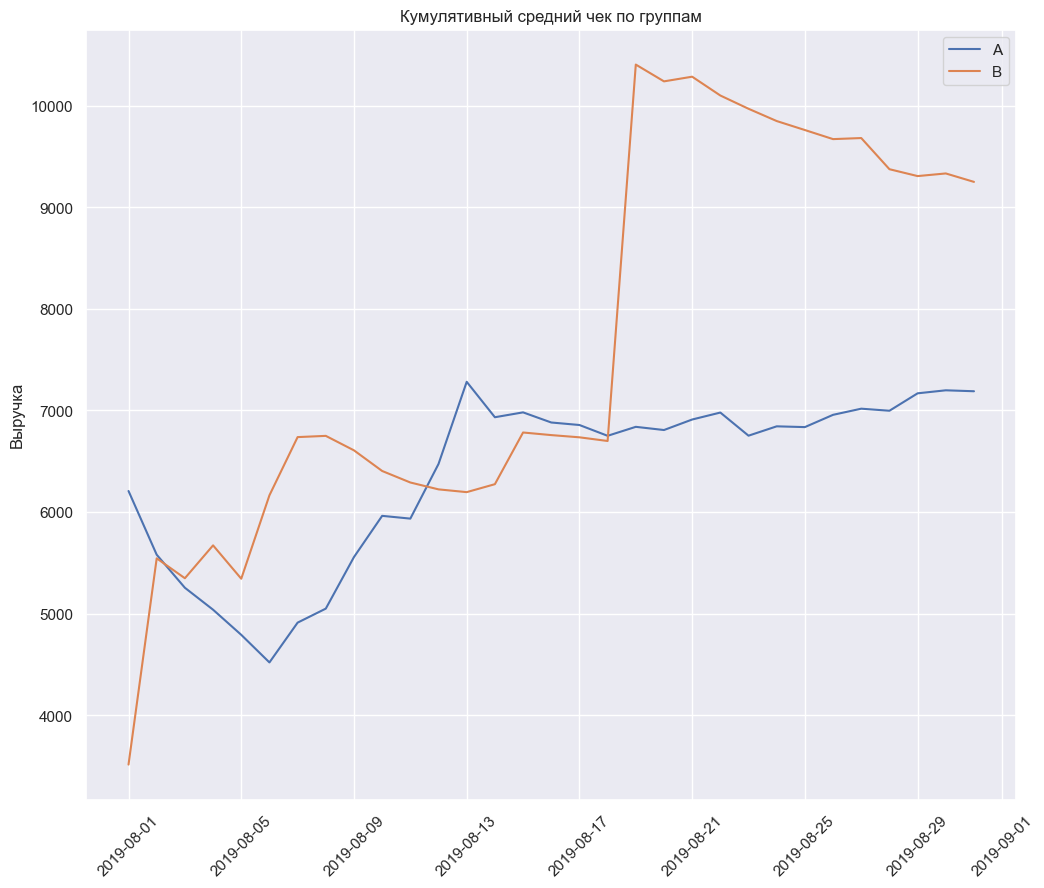

In [26]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='А')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='В')
plt.title('Кумулятивный средний чек по группам')
plt.ylabel('Выручка')
plt.xticks(rotation=45)
plt.legend()
plt.show()

**Вывод:**

- В ту же дату 2019-08-19 средний чек в группе В резко растет. 

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Сделаем выводы и предположения.

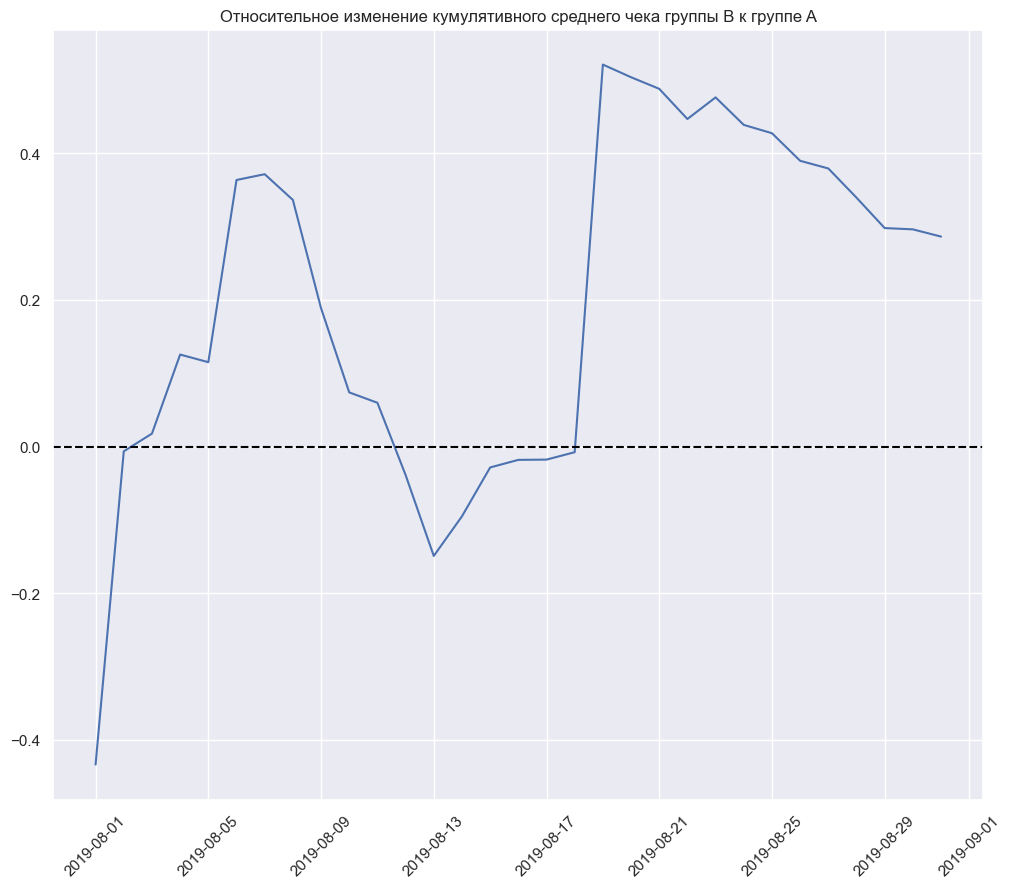

In [29]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/
          mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/
          mergedCumulativeRevenue['ordersA'])-1)
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

**Вывод:**

Анализируя данные, можно сделать вывод, что средний чек в группе B, как и в предыдущих случаях, подвержен резким изменениям, включая значительные скачки, которые, вероятно, обусловлены нестандартными заказами. Можно предположить, что группа B привлекла покупателей с высокими суммами заказов благодаря рекламной акции или другому событию.

### Построим график кумулятивного среднего количества заказов на посетителя по группам. Сделаем выводы и предположения.

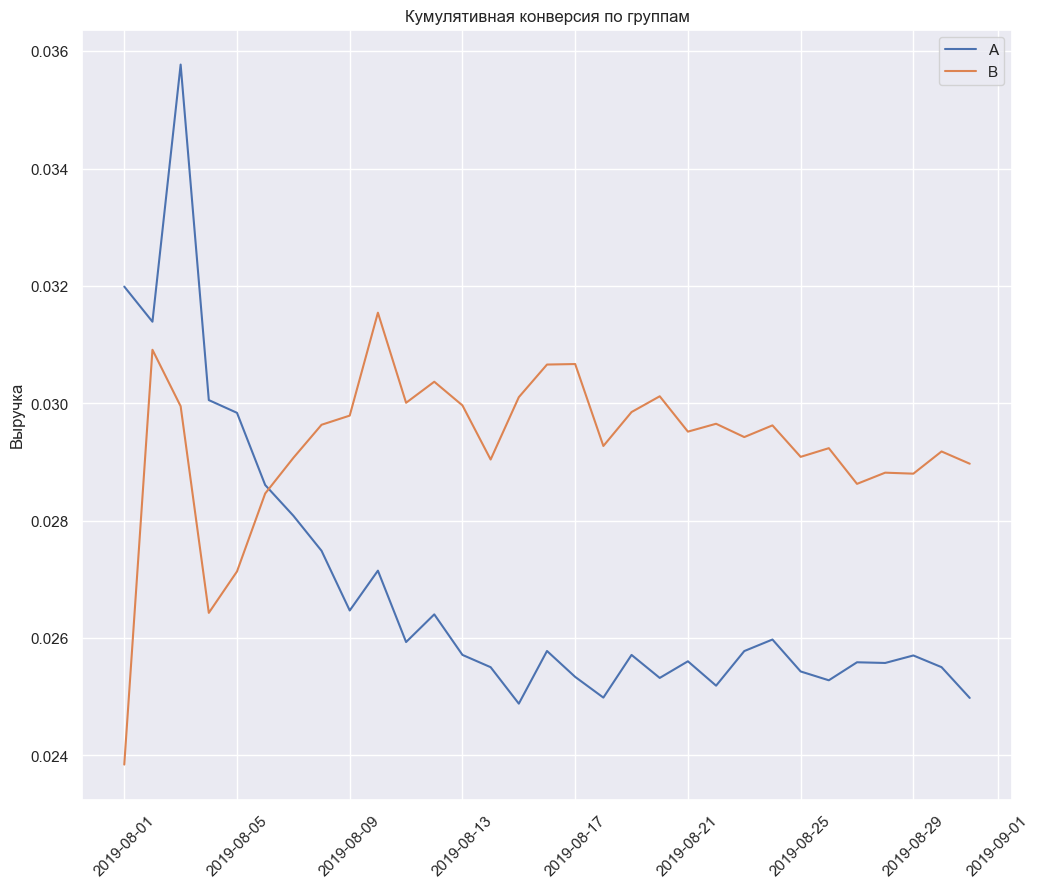

In [32]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('Кумулятивная конверсия по группам')
plt.ylabel('Выручка')
plt.xticks(rotation=45)
plt.legend()
plt.show()

**Вывод:**

Группа B показывает стабильную повышенную совокупную конверсию, что может указывать на положительный эффект от внесённых изменений. Возможно, в группе B были проведены мероприятия, которые улучшили пользовательский опыт и увеличили конверсию. В то же время группа A могла столкнуться с отрицательными факторами, снижающими её конверсию.

### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделаем выводы и предположения.

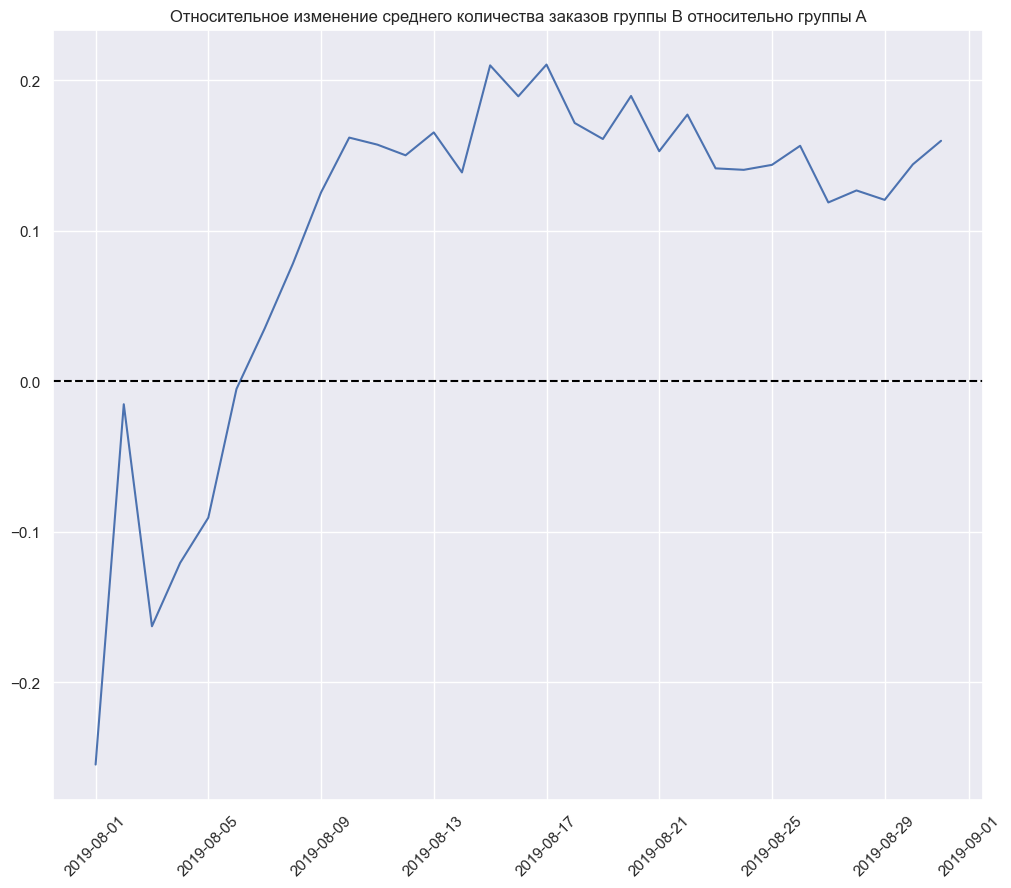

In [35]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], \
left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/
mergedCumulativeConversions['conversionA']-1, 
)
plt.title('Относительное изменение среднего количества заказов группы B относительно группы A')
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)

plt.show()

**Вывод:**

В начале теста группа B проигрывала группе A, но затем быстро вырвалась вперед. С 2019-08-06 и на протяжении всего теста группа В имеет устойчиво более высокий коэффициент конверсии по сравнению с группой A. 

### Построим точечный график количества заказов по пользователям. Сделаем выводы и предположения.

In [38]:
# Подсчитаем количество заказов по пользователям
ordersByUsers = (
    orders_correct.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique}))

ordersByUsers.columns = ['user_id','orders']

ordersByUsers.sort_values(by='orders',ascending=False).head(10)

,user_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


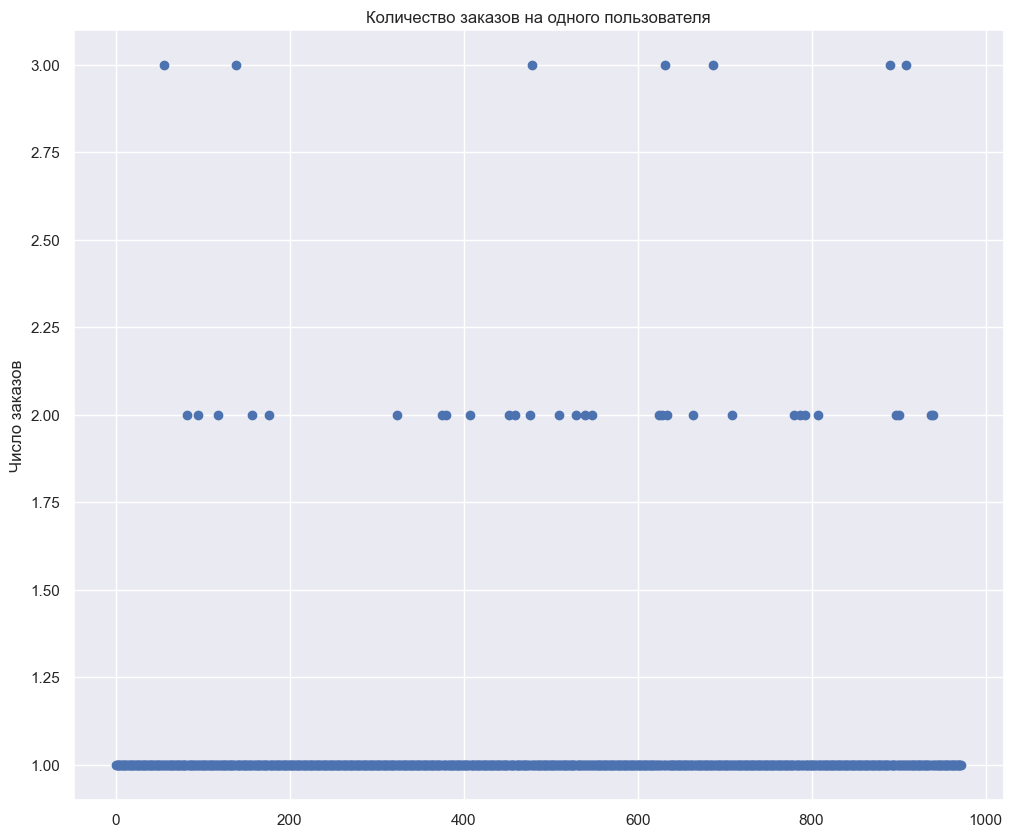

In [39]:
# Построим точечную диаграмму числа заказов на одного пользователя
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Количество заказов на одного пользователя')
plt.ylabel('Число заказов')
plt.show()

**Вывод:**

Большинство пользователей совершают 1 заказ, намного реже 2-3 заказа.   

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [42]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

In [43]:
# Посмотрим точнее с 95 по 99 перцентили
np.percentile(ordersByUsers['orders'], [95, 96, 97, 98, 99])

array([1., 1., 2., 2., 2.])

**Вывод:**

Количество заказов сократилось заметно, а вот чек не сильно уменьшился. Поэтому, границей для определения аномальных пользователей будем считать количество заказов свыше 2. 

### Построим точечный график стоимостей заказов. Сделаем выводы и предположения.

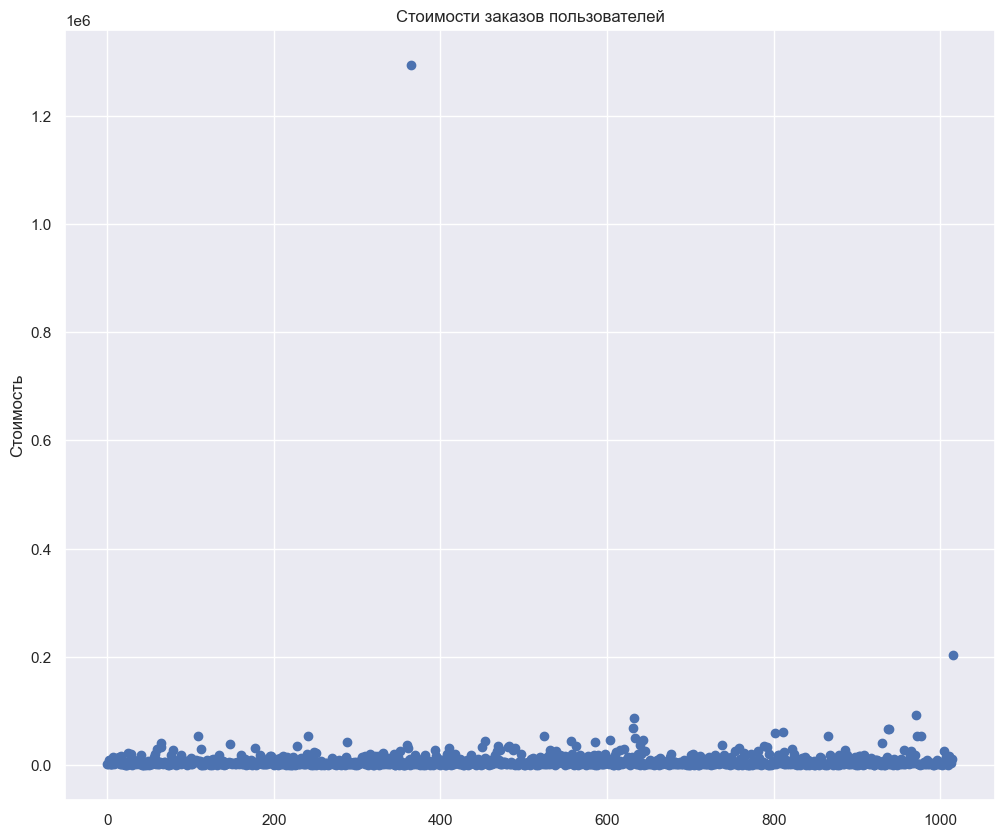

In [46]:
x_values = pd.Series(range(0,len(orders_correct['revenue'])))

plt.scatter(x_values, orders_correct['revenue']) 
plt.title('Стоимости заказов пользователей')
plt.ylabel('Стоимость')
plt.show()

**Вывод:**

На графике выделяются два заказа с аномально высокой стоимостью: первый свыше 1,2 млн и второй около 200 000. Основная масса заказов не превышает 100 000. 

### Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [49]:
np.percentile(orders_correct['revenue'], [95, 99])

array([26785., 53904.])

**Вывод:**

99% заказов имеют выручку не более 58233.2 - это и будет нашей границей для определения аномальных заказов.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделаем выводы и предположения.

Для групп A и B рассчитаем ежедневное и кумулятивное количество посетителей. Объединим данные по заказам и посещениям, создадим таблицу, содержащую накопительные значения посетителей по каждой дате.

In [53]:
# соберем в дф количество пользователей группы А за каждый день
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
# соберем в дф кумулятивное количество пользователей группы А за каждый день
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# соберем в дф количество пользователей группы В за каждый день

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
# соберем в дф кумулятивное количество пользователей группы В за каждый день

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# соберем в дф количество заказов и выручку группы А по дням    
ordersADaily = (
    orders_correct[orders_correct['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
# соберем в дф накопительное количество заказов и накопленную выручку группы А по дням    
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]
# соберем в дф количество заказов и выручку группы В по дням    
ordersBDaily = (
    orders_correct[orders_correct['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']
# соберем в дф накопительное количество заказов и накопленную выручку группы В по дням
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

# объединим полученные данные в один датафрейм    
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Напомним названия столбцов данных:
* `date` — дата;
* `ordersPerDateA` — количество заказов в выбранную дату в группе A;
* `revenuePerDateA` — суммарная выручка в выбранную дату в группе A;
* `ordersPerDateB` — количество заказов в выбранную дату в группе B;
* `revenuePerDateB` — суммарная выручка в выбранную дату в группе B;
* `ordersCummulativeA` — суммарное число заказов до выбранной даты включительно в группе A;
* `revenueCummulativeA` — суммарная выручка до выбранной даты включительно в группе A;
* `ordersCummulativeB` — суммарное количество заказов до выбранной даты включительно в группе B;
* `revenueCummulativeB` — суммарная выручка до выбранной даты включительно в группе B;
* `visitorsPerDateA` — количество пользователей в выбранную дату в группе A;
* `visitorsPerDateB` — количество пользователей в выбранную дату в группе B;
* `visitorsCummulativeA` — количество пользователей до выбранной даты включительно в группе A;
* `visitorsCummulativeB` — количество пользователей до выбранной даты включительно в группе B.

Для определения статистической значимости различий в среднем количестве заказов между группами создадим переменные ordersByUsersA и ordersByUsersB со столбцами userId и orders. В эти переменные внесём данные о заказах пользователей, которые хотя бы один раз совершили покупку.

In [55]:
ordersByUsersA = (
    orders_correct[orders_correct['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders_correct[orders_correct['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

In [56]:
# Создаём выборки количества заказов для групп A и B. Тем, кто ничего не заказал, будут соответствовать нули.
sampleA = pd.concat(
    [ordersByUsersA['orders'], 
    pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
    name='orders')], axis=0)

sampleB = pd.concat(
    [ordersByUsersB['orders'],
    pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
    name='orders')], axis=0)

Сформулируем гипотезы. 
* Н0: различий в среднем количестве заказов между группами нет. 
* Н1: различия в среднем количестве заказов между группами есть.

Возьмем уровень значимости равный 5%

In [58]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительное изменение количества заказов клиентов группы B к группе A: {0:.3f}'.format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.011
Относительное изменение количества заказов клиентов группы B к группе A: 0.160


**Вывод:**
* Значение p-value 0.011 меньше уровня значимости, отвергаем нулевую гипотезу. Будем считать, что есть статистически значимые различия в среднем количестве заказов между двумя группами по «сырым» данным. 
* Относительный прирост среднего количества заказов в группе В по отношению к группе А составляет 16% возможно это положительное влияние внесенных изменений. 

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделаем выводы и предположения.

Сформулируем гипотезы.

* Н0: различий в среднем чеке между группами нет.
* Н1: различия в среднем чеке между группами есть.

Возьмем уровень значимости равный 5%

In [62]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(orders_correct[orders_correct['group']=='A']['revenue'], orders_correct[orders_correct['group']=='B']['revenue'])[1]))

print('Относительное изменение среднего чека клиентов группы B к группе A: {0:.3f}'.format(orders_correct[orders_correct['group']=='B']['revenue'].mean()/orders_correct[orders_correct['group']=='A']['revenue'].mean()-1)) 

p-value: 0.829
Относительное изменение среднего чека клиентов группы B к группе A: 0.287


**Вывод:**

* Значение p-value 0.829 больше уровня значимости, следовательно у нас нет оснований отвергнуть нулевую гипотезу. Будем считать, что на "сырых" данных статистически значимых отличий в среднем чеке заказа клиентов групп А и В нет.
* Наблюдаемое различие среднего чека клиентов группы В в 28,7% не явлется статистически значимым.    
  

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделаем выводы и предположения.

Ранее мы нашли 95-й и 99-й перцентили средних чеков, они равны 26785 и 53904  рублям. 
А 95-й и 99-й перцентили количества заказов на одного пользователя равны 1 и 2 заказа на пользователя.
Примем за аномальных пользователей тех, кто совершил свыше 2 заказов или совершил заказ дороже 53904 рублей. Так мы уберём 1% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 53904 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers. 

In [66]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 2]['userId']], axis = 0)
usersWithExpensiveOrders = orders_correct[orders_correct['revenue'] > 53904 ]['visitor_id']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

print('Всего аномальных пользователей:' ,abnormalUsers.shape[0]) 
abnormalUsers.head(5)

Всего аномальных пользователей: 16


1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
dtype: int64

Сформулируем гипотезы.

* Н0: различий в среднем количестве заказов между группами по «очищенным» данным нет.
* Н1: различия в среднем количестве заказов между группами по «очищенным» данным есть.

Возьмем уровень значимости равный 5%

In [68]:
sampleAFiltered = pd.concat(
    [ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],
    pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],
    axis=0)

sampleBFiltered = pd.concat(
    [ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],
    pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],
    axis=0)

print('p-value: {0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительное изменение количества заказов клиентов группы B к группе A на "очищеных" данных: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value: 0.00702
Относительное изменение количества заказов клиентов группы B к группе A на "очищеных" данных: 0.189


**Вывод:**
* Значение p-value 0.00702 меньше уровня значимости, отвергаем нулевую гипотезу. Будем считать, что есть статистически значимые различия в среднем количестве заказов между двумя группами по «очищеным» данным.
* Относительный прирост среднего количества заказов в группе В по отношению к группе А составляет 18,9%.

На "очищеных" данных также как на "сырых" наблюдаем лучшую конверсию у клиентов группы В.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделаем выводы и предположения

Сформулируем гипотезы.

* Н0: различий в среднем чеке между группами по «очищенным» данным нет.
* Н1: различия в среднем чеке между группами по «очищенным» данным есть.

Возьмем уровень значимости равный 5%

In [72]:
print(
    'p-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders_correct[
                np.logical_and(
                    orders_correct['group'] == 'A',
                    np.logical_not(orders_correct['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders_correct[
                np.logical_and(
                    orders_correct['group'] == 'B',
                    np.logical_not(orders_correct['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    'Относительное изменение среднего чека клиентов группы B к группе A на "очищеных" данных: {0:.3f}'.format(
        orders_correct[
            np.logical_and(
                orders_correct['group'] == 'B',
                np.logical_not(orders_correct['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders_correct[
            np.logical_and(
                orders_correct['group'] == 'A',
                np.logical_not(orders_correct['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 


p-value: 0.788
Относительное изменение среднего чека клиентов группы B к группе A на "очищеных" данных: -0.032


**Вывод:**
* Значение p-value 0.788 больше уровня значимости, следовательно у нас нет оснований отвергнуть нулевую гипотезу. Будем считать, что на "очищеных" данных, так же как и на "сырых" статистически значимых отличий в среднем чеке заказа клиентов групп А и В нет.
* Но средний чек клиентов группы В на "очищеных" данных меньше на 3,2%. Можем считать это различие незначительным.

### Примем решение по результатам теста. 
На основании результатов теста можно рекомендовать остановить тест и признать победу группы В.

Группа B демонстрирует уверенное превосходство в показателях конверсии, несмотря на отсутствие статистически значимых различий в средних значениях суммы чека между группами, как по исходным, так и по обработанным данным. Графический анализ также указывает на устойчивое преимущество группы B, которая либо сохраняет текущие средние значения, либо демонстрирует тенденцию к росту. Таким образом, группа B оказывается более результативной, а изменения, примененные в ней, могут быть применены ко всем остальным клиентам.